In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Inverting sequence

### Grammar
#### output the first two numbers
ex [43, 3, 28, 34, 33] -> [43, 3]
#### Inverting sequence
ex) '1', '2', '5', '2', '2', '6', '5', '1' -> '1', '5', '6', '2', '2', '5', '2', '1'

In [2]:
from my_utils import Dictionary

n_unique = 10

src_dict = Dictionary(['<EOS>'])
tgt_dict = Dictionary(['<BOS>', '<EOS>'])
for n in range(n_unique):
    src_dict.add_word(str(n))
    tgt_dict.add_word(str(n))

In [3]:
from my_utils.toy_data import first_two, invert_seq
train = invert_seq(5000, n_unique=n_unique)
test = invert_seq(100, n_unique=n_unique)

In [4]:
from my_utils import DataLoader
from torch_models.utils import seq2seq, get_device

def numericalize(dataset, src_dict, tgt_dict):
    numericalized = [([src_dict(s) for s in src], [tgt_dict(t) for t in tgt]) for src, tgt in dataset]
    return numericalized

device = get_device()
train_loader = DataLoader(numericalize(train, src_dict, tgt_dict), batch_size=64, trans_func=seq2seq)
test_loader = DataLoader(numericalize(test, src_dict, tgt_dict), batch_size=16, trans_func=seq2seq)

===== Device =====
cpu


In [5]:
from torch_models import AttnSeq2Seq, Seq2Seq
dim = 100
model = AttnSeq2Seq(dim, dim, len(src_dict), len(tgt_dict),
                    tgt_BOS=tgt_dict('<BOS>'), tgt_EOS=tgt_dict('<EOS>'), src_EOS=src_dict('<EOS>'),
                    num_layers=1, bidirectional=True)
print(model)

AttnSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(12, 100, padding_idx=11)
    (lstm): LSTM(100, 100, bidirectional=True)
  )
  (decoder): LSTMEncoder(
    (embedding): Embedding(13, 100, padding_idx=12)
    (lstm): LSTM(100, 200)
  )
  (out_mlp): MLP(
    (fc_out): Linear(in_features=400, out_features=12, bias=True)
    (dropout): Dropout(p=0)
    (criterion): CrossEntropyLoss()
    (activation): Tanh()
  )
)


In [6]:
from my_utils import Trainer, EvaluatorSeq
from torch.optim import Adam

optimizer = Adam(model.parameters())

evaluator = EvaluatorSeq(model, test_loader, measure='BLEU')

trainer = Trainer(model, train_loader)
trainer.train(optimizer, max_epoch=10,
              evaluator=evaluator, score_monitor=None, show_log=True, hook_func=None)

/Users/linghan/anaconda/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/linghan/anaconda/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/linghan/anaconda/lib/python3.5/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


epoch 0  	loss: 1.6621020247664633	BLEU: 0.6443	
epoch 1  	loss: 0.7749300052093554	BLEU: 0.8431	
epoch 2  	loss: 0.418810912702657	BLEU: 0.8909	
epoch 3  	loss: 0.255156160721296	BLEU: 0.9128	
epoch 4  	loss: 0.15775523485639428	BLEU: 0.9046	
epoch 5  	loss: 0.10301995267973671	BLEU: 0.9122	
epoch 6  	loss: 0.07062211401666267	BLEU: 0.904	
epoch 7  	loss: 0.05221743952435783	BLEU: 0.9071	
epoch 8  	loss: 0.040479579115215734	BLEU: 0.9161	
epoch 9  	loss: 0.031948909517141834	BLEU: 0.9296	


In [7]:
iter(train_loader)
inputs, target = next(train_loader)
l = 10
generated, attn = model.predict(inputs, attention=True)
print('======= input ======')
for seq in inputs[:l]:
    print([src_dict[s.item()] for s in seq])
print('======= output ======')
for seq in generated[:l]:
    print([tgt_dict[s] for s in seq])

======= input ======
['8', '7', '0', '1', '4']
['7', '9', '8', '9']
['9', '1', '1', '3']
['2', '4', '2', '7', '4']
['1', '0', '7', '7']
['5', '4', '5', '7', '1']
['8', '6', '1', '6', '0']
['9', '8', '4', '1']
['1', '9', '9']
['2', '2', '6', '2']
======= output ======
['4', '1', '0', '7', '8']
['9', '8', '9', '7']
['3', '1', '1', '9']
['4', '7', '2', '4', '2']
['7', '7', '0', '1']
['1', '7', '5', '4', '5']
['0', '6', '1', '8']
['1', '4', '8', '9']
['9', '9', '1']
['2', '6', '2', '2']


<IPython.core.display.Javascript object>


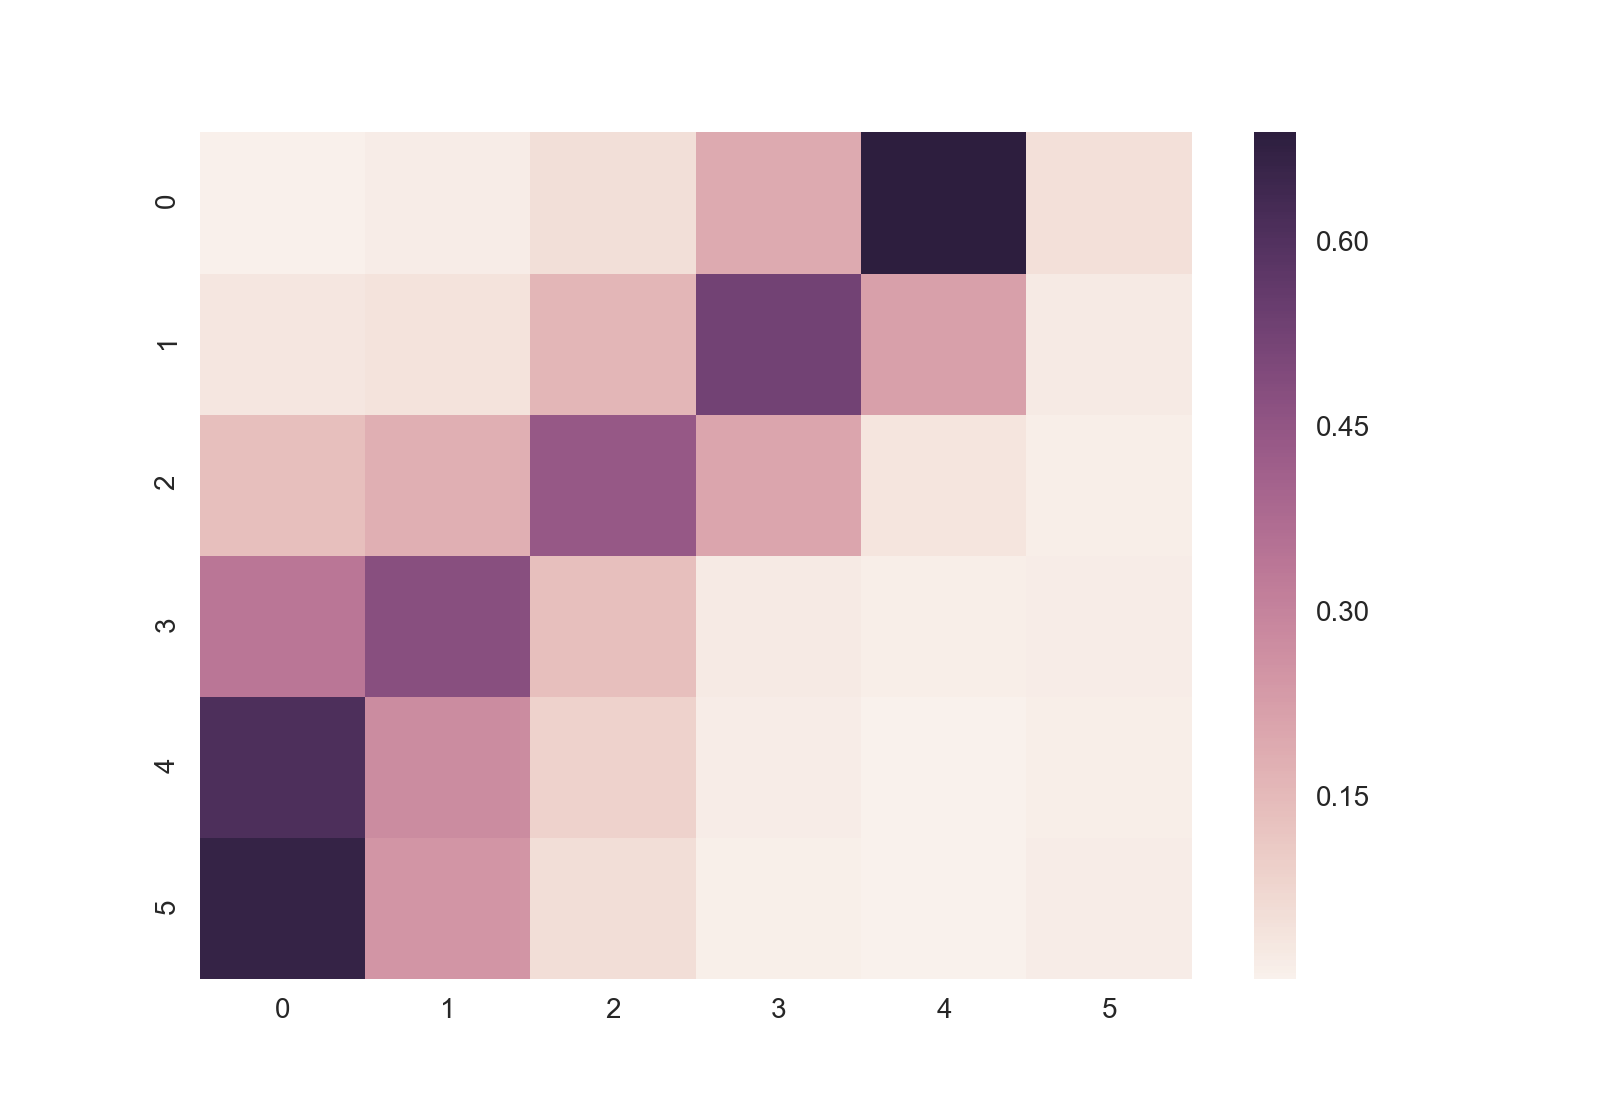

In [8]:
import torch
import seaborn as sns
sns.heatmap(torch.stack(attn[3]).data.numpy())